# H(z) Reconstrution via Gaussian Process (GP)

 /home/lazarolima/.local/lib/python3.12/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /home/lazarolima/.local/lib/python3.12/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/lazarolima/.local/lib/python3.12/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/lazarolima/.local/lib/python3.12/site-packages/GPy/kern/src/rbf.py:178: RuntimeWarning:invalid value encountered in multiply


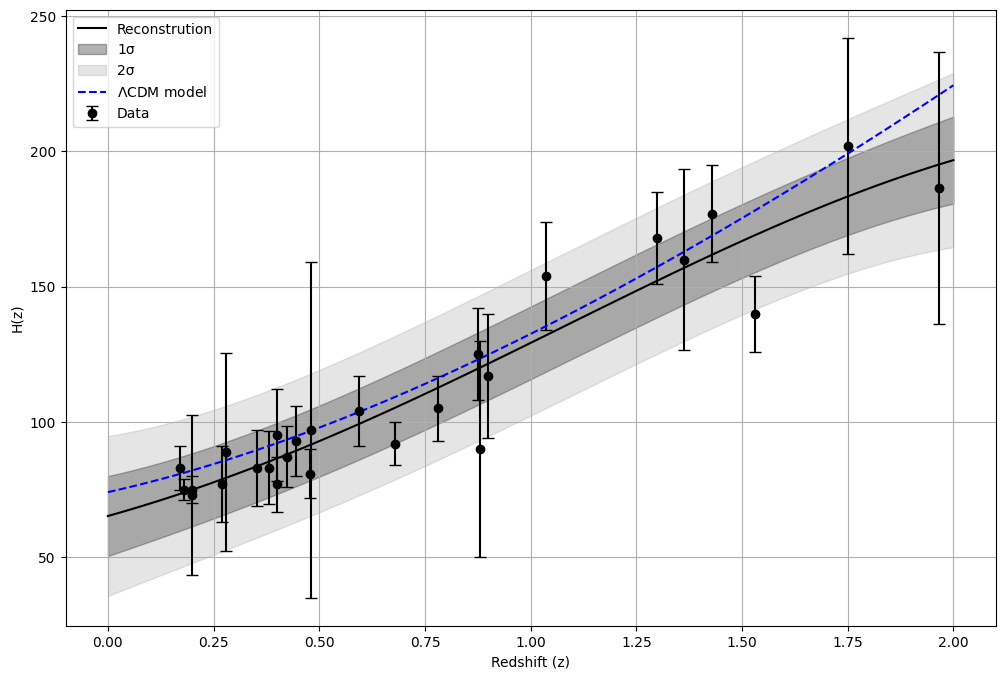

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import gaussian_process as gp
from obs_data import H_data
from equations import FiducialModel

fiducial_model = FiducialModel()

z_values = H_data.z_func()
H_obs = H_data.H_func()
errors = H_data.errors_func()

# Obter valores de predição
mean, var, mean_deriv, var_deriv = gp.pred()

# Modelo LambdaCDM plano
z_test = gp.z_pred()
H_theory = fiducial_model.H_padrao(z_test.flatten())

# Plotar os resultados
plt.figure(figsize=(12, 8))

# Dados originais com barras de erro
plt.errorbar(z_values, H_obs, yerr=errors, fmt='o', capsize=4, color='k', label='Data')

# Função predita pelo GP
plt.plot(z_test, mean, 'k-', label='Reconstrution')

# Adicionar curvas sombreadas de 1σ e 2σ
plt.fill_between(z_test.flatten(), 
                 mean.flatten() - 1*np.sqrt(var.flatten()), 
                 mean.flatten() + 1*np.sqrt(var.flatten()), 
                 alpha=0.3, color='k', label='1σ')
plt.fill_between(z_test.flatten(), 
                 mean.flatten() - 2*np.sqrt(var.flatten()), 
                 mean.flatten() + 2*np.sqrt(var.flatten()), 
                 alpha=0.2, color='gray', label='2σ')

plt.plot(z_test, H_theory, 'b--', label='$\\Lambda$CDM model')

plt.xlabel('Redshift (z)')
plt.ylabel('H(z)')
plt.legend()
plt.grid(True)
plt.savefig('H_reconstructed.png', dpi=600)


#### Generating FRBs Mock data 

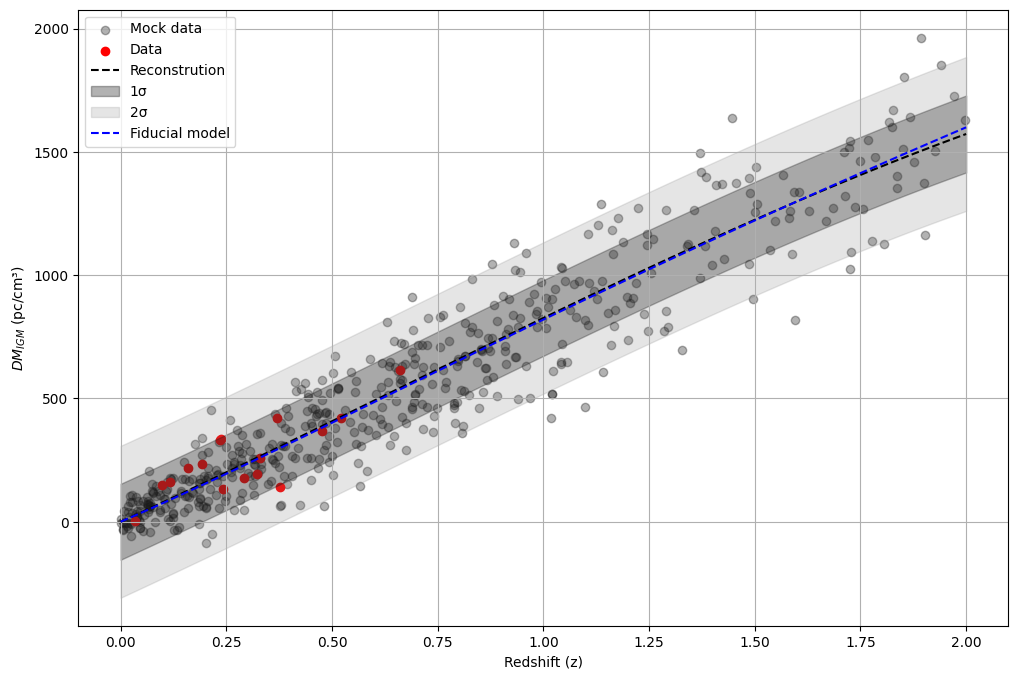

In [3]:
from mock import RedshiftSimulation
import obs_data as od

# Parâmetros para gerar novos dados
n_new = 500  # Número de novos pontos de dados
z_max = 2  # Máximo redshift

# Criar uma instância da classe RedshiftSimulation
sim = RedshiftSimulation(n_new, z_max)

# Gerar novos dados
sim.generate_redshifts()
sim.simulate_DM_IGM()

# Obter os resultados
new_z = sim.get_new_z()
DM_IGM_sim = sim.get_DM_IGM_sim()

# Obter valores de predição
mean1, var1, mean_deriv1, var_deriv1 = gp.pred_new()

# Plotar os resultados
plt.figure(figsize=(12, 8))

# Dados originais com barras de erro
plt.scatter(new_z, DM_IGM_sim, alpha=0.3, color='k', label='Mock data')
plt.scatter(od.z_obs, od.DM_IGM_obs, color='r', label='Data')

# Função predita pelo GP
plt.plot(gp.z_pred(), mean1, 'k--', label='Reconstrution')

# Adicionar curvas sombreadas de 1σ e 2σ
plt.fill_between(gp.z_pred().flatten(), 
                 mean1.flatten() - 1*np.sqrt(var1.flatten()), 
                 mean1.flatten() + 1*np.sqrt(var1.flatten()), 
                 alpha=0.3, color='k', label='1σ')
plt.fill_between(gp.z_pred().flatten(), 
                 mean1.flatten() - 2*np.sqrt(var1.flatten()), 
                 mean1.flatten() + 2*np.sqrt(var1.flatten()), 
                 alpha=0.2, color='gray', label='2σ')

# Modelo fiducial
# Create an instance of the model
from equations import FiducialModel

model = FiducialModel()

dm_igm_theory = model.DM_IGM(gp.z_pred().flatten())
plt.plot(gp.z_pred(), dm_igm_theory, 'b--', label='Fiducial model')

plt.xlabel('Redshift (z)')
plt.ylabel('$DM_{IGM}$ (pc/cm³)')
plt.legend()
plt.grid(True)
plt.savefig('DM_IGM_reconstructed.png', dpi=600)

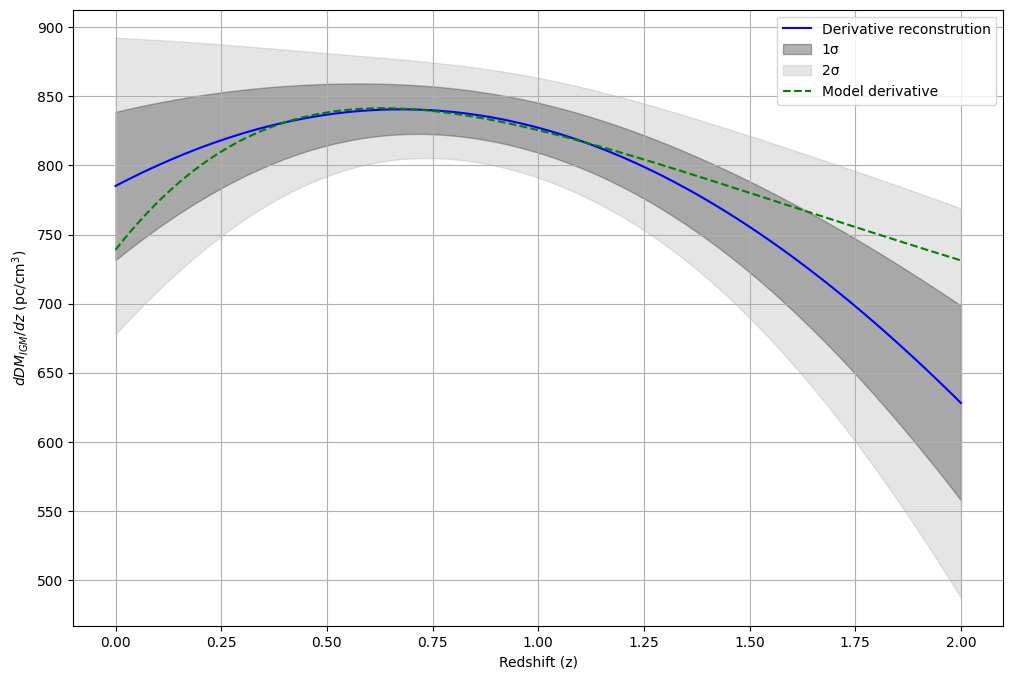

In [4]:
# Plotar as derivadas
plt.figure(figsize=(12, 8))
plt.plot(gp.z_pred(), mean_deriv1.flatten(), 'b-', label='Derivative reconstrution')

# Adicionar curvas sombreadas de 1σ e 2σ para a derivada
plt.fill_between(gp.z_pred().flatten(), 
                 mean_deriv1.flatten() - 1*np.sqrt(var_deriv1.flatten()), 
                 mean_deriv1.flatten() + 1*np.sqrt(var_deriv1.flatten()), 
                 alpha=0.3, color='k', label='1σ')
plt.fill_between(gp.z_pred().flatten(), 
                 mean_deriv1.flatten() - 2*np.sqrt(var_deriv1.flatten()), 
                 mean_deriv1.flatten() + 2*np.sqrt(var_deriv1.flatten()), 
                 alpha=0.2, color='gray', label='2σ')

# Derivada de DM_IGM
dm_igm_deriv = model.I(gp.z_pred().flatten())
plt.plot(gp.z_pred().flatten(), dm_igm_deriv, 'g--', label='Model derivative')

plt.xlabel('Redshift (z)')
plt.ylabel('$dDM_{IGM}/dz$ (pc/cm$^{3}$)')
plt.legend()
plt.grid(True)
plt.savefig('dDM_IGM_reconstructed.png', dpi=600)

In [7]:
import ultranest
from likelihood import Priors as P, LikelihoodFunction as LF

sampler1 = ultranest.ReactiveNestedSampler(P.parameters1, LF.log_likelihood1, P.prior_transform1)
sampler2 = ultranest.ReactiveNestedSampler(P.parameters2, LF.log_likelihood2, P.prior_transform2)
sampler3 = ultranest.ReactiveNestedSampler(P.parameters2, LF.log_likelihood3, P.prior_transform2)
sampler4 = ultranest.ReactiveNestedSampler(P.parameters3, LF.log_likelihood4, P.prior_transform3)

In [8]:
result1 = sampler1.run(min_num_live_points=400)
sampler1.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-8  34 [-8.3387..-8.3387]*| it/evals=2560/3049 eff=96.6402% N=400 0   
[ultranest] Likelihood function evaluations: 3070
[ultranest]   logZ = -11.48 +- 0.06876
[ultranest] Effective samples strategy satisfied (ESS = 1282.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.08, need <0.5)
[ultranest]   logZ error budget: single: 0.08 bs:0.07 tail:0.04 total:0.08 required:<0.50
[ultranest] done iterating.

logZ = -11.461 +- 0.144
  single instance: logZ = -11.461 +- 0.081
  bootstrapped   : logZ = -11.478 +- 0.140
  tail           : logZ = +- 0.035
insert order U test : converged: True correlation: inf iterations

    $f_{IGM}$           : 0.703 │ ▁ ▁▁▁▁▂▂▂▂▄▄▆▇▆▆▇▇▇▆▅▅▅▄▂▃▂▁▁▁▁▁▁▁▁ ▁ │0.840     0.766 +- 0.018



In [9]:
result2 = sampler2.run(min_num_live_points=400)
sampler2.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-8  34 [-8.3800..-8.3800]*| it/evals=4680/6364 eff=78.4708% N=400 00   0  
[ultranest] Likelihood function evaluations: 6380
[ultranest]   logZ = -15.48 +- 0.0982
[ultranest] Effective samples strategy satisfied (ESS = 1676.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.12 bs:0.10 tail:0.01 total:0.10 required:<0.50
[ultranest] done iterating.

logZ = -15.484 +- 0.276
  single instance: logZ = -15.484 +- 0.122
  bootstrapped   : logZ = -15.477 +- 0.275
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    $f_{IGM}$           : 0.629 │ ▁  ▁▁▁▁▁▁▁▁▁▁▂▂▃▃▅▅▆▇▇▇▇▆▅▄▃▂▂▁▁▁▁▁ ▁ │0.837     0.747 +- 0.024
    $\alpha$            : 0.000 │▇▇▆▅▅▅▅▄▅▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ │0.312     0.059 +- 0.049



In [10]:
result3 = sampler3.run(min_num_live_points=400)
sampler3.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-8  34 [-8.3741..-8.3741]*| it/evals=4400/6019 eff=78.3057% N=400 00    
[ultranest] Likelihood function evaluations: 6032
[ultranest]   logZ = -14.78 +- 0.1109
[ultranest] Effective samples strategy satisfied (ESS = 1674.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.11 bs:0.11 tail:0.01 total:0.11 required:<0.50
[ultranest] done iterating.

logZ = -14.777 +- 0.281
  single instance: logZ = -14.777 +- 0.114
  bootstrapped   : logZ = -14.784 +- 0.281
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    $f_{IGM}$           : 0.551 │ ▁  ▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▃▄▄▅▇▇▇▇▇▇▅▄▃▂▁▁▁▁ │0.827     0.734 +- 0.032
    $\alpha$            : 0.00  │▇▇▇▅▅▅▄▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁   ▁     ▁ │0.86      0.13 +- 0.10



In [11]:
result4 = sampler4.run(min_num_live_points=400)
sampler4.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-8  96 [-7.9689..-7.9689]*| it/evals=4800/9041 eff=55.5491% N=400 00    0  400 
[ultranest] Likelihood function evaluations: 9092
[ultranest]   logZ = -15.41 +- 0.1007
[ultranest] Effective samples strategy satisfied (ESS = 1590.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.13 bs:0.10 tail:0.01 total:0.10 required:<0.50
[ultranest] done iterating.

logZ = -15.441 +- 0.198
  single instance: logZ = -15.441 +- 0.128
  bootstrapped   : logZ = -15.409 +- 0.197
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    $f_{IGM}$           : 0.342 │ ▁▁▁▁▁▁▁▁▁▂▂▃▃▄▅▆▇▆▇▇▆▇▆▅▄▃▃▂▁▁▁▁▁▁▁▁▁▁│1.000     0.680 +- 0.086
    $s$                 : -0.481│ ▁   ▁▁ ▁▁▁▁▁▁▁▁▁▁▁▂▁▂▃▃▄▆▇▇▇▇▇▆▅▃▁▁▁▁ │0.110     -0.061 +- 0.063



In [12]:
from getdist import plots, MCSamples

# Extraindo amostras dos resultados
samples1 = result1['samples']
samples2 = result2['samples']
samples3 = result3['samples']
samples4 = result4['samples']

# Criando objetos MCSamples com os dados
labels1 = ['f_{IGM,0}']
names1 = ['f_IGM']
mcsamples1 = MCSamples(samples=samples1, names=names1, labels=labels1)

labels2 = ['f_{IGM,0}', '\\alpha']
names2 = ['f_IGM', 'alpha']
mcsamples2 = MCSamples(samples=samples2, names=names2, labels=labels2)
mcsamples3 = MCSamples(samples=samples3, names=names2, labels=labels2)

labels3 = ['f_{IGM,0}', 's']
names3 = ['f_IGM', 's']
mcsamples4 = MCSamples(samples=samples4, names=names3, labels=labels3)

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


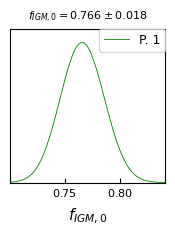

In [13]:
# Plotando os Triangle plots
g = plots.get_subplot_plotter()
mcsamples1.updateSettings({'smooth_scale_2D': 0.9, 'smooth_scale_1D': 0.9})
g.settings.num_plot_contours = 2
g.triangle_plot(mcsamples1, filled=True, contour_colors=['green'], 
                legend_labels=['P. 1'], 
                title_limit=1)
g.export('Figuras/H_p1.png', dpi=600)

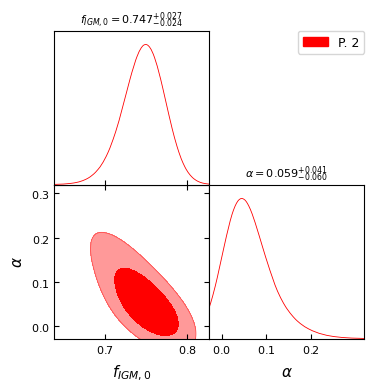

In [14]:
# Plotando os Triangle plots
g = plots.get_subplot_plotter()
mcsamples2.updateSettings({'smooth_scale_2D': 0.9, 'smooth_scale_1D': 0.9})
g.settings.num_plot_contours = 2
g.triangle_plot(mcsamples2, filled=True, contour_colors=['red'],
                legend_labels=['P. 2'], title_limit=1)
g.export('Figuras/H_p2.png', dpi=600)

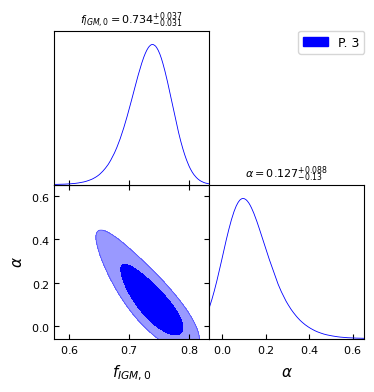

In [15]:
# Plotando os Triangle plots
g = plots.get_subplot_plotter()
mcsamples3.updateSettings({'smooth_scale_2D': 0.9, 'smooth_scale_1D': 0.9})
g.settings.num_plot_contours = 2
g.triangle_plot(mcsamples3, filled=True, contour_colors=['blue'],
                legend_labels=['P. 3'], title_limit=1)
g.export('Figuras/H_p3.png', dpi=600)

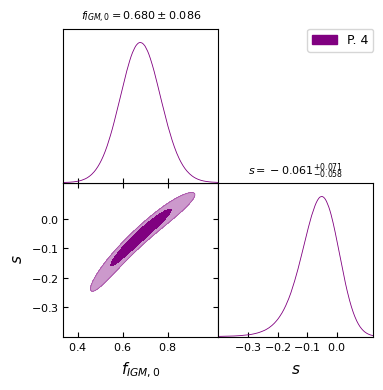

In [16]:
# Plotando os Triangle plots
g = plots.get_subplot_plotter()
mcsamples4.updateSettings({'smooth_scale_2D': 0.9, 'smooth_scale_1D': 0.9})
g.settings.num_plot_contours = 2
g.triangle_plot(mcsamples4, filled=True, contour_colors=['purple'],
                legend_labels=['P. 4'], title_limit=1)
g.export('Figuras/H_p4.png', dpi=600)

KeyboardInterrupt: 

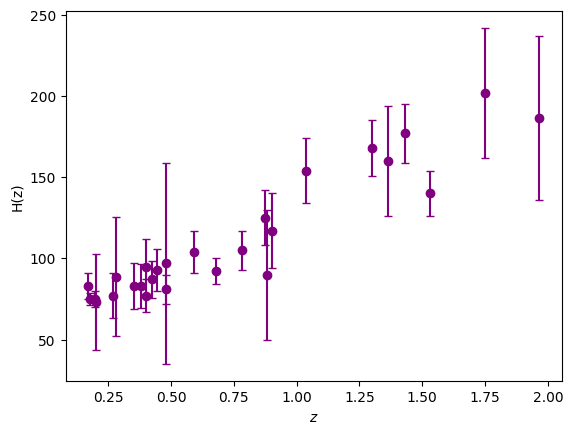

In [18]:
from ultranest.plot import PredictionBand
from equations import H_Model

plt.figure()
plt.xlabel('$z$')
plt.ylabel('H(z)')
plt.errorbar(x=z_values, y=H_obs, yerr=errors, marker='o', capsize=3, ls=' ', color='purple', label='$DM_{ext}^{obs}$')

band = PredictionBand(z_test.flatten())

# go through the solutions
for f_IGM  in sampler1.results['samples']:
    # compute for each time the y value
    model = H_Model()
    band.add(model.H_p1(z_test.flatten(), f_IGM=f_IGM))

band.line(color='k', linestyle='--', label='$H_{P1}$', linewidth=1.5)
# add 1 sigma quantile
band.shade(color='k', alpha=0.3)
# add wider quantile (0.01 .. 0.99)
band.shade(q=0.49, color='gray', alpha=0.2)

plt.legend()
plt.savefig('Figuras/H_bestfit.png', format='png', dpi=600)